# 第四次实战：TensorFlow-Keras构建wide&deep回归模型

In [1]:
# 导入
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl,np,pd,sklearn,tf,keras:
    print(module.__name__,module.__version__)

2.0.0
sys.version_info(major=3, minor=6, micro=10, releaselevel='final', serial=0)
matplotlib 3.1.2
numpy 1.18.1
pandas 0.25.3
sklearn 0.22.1
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


## 实战开始

### 数据读取和展示

In [2]:
# 导入数据集 房价预测
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [3]:
# 切分数据集
from sklearn.model_selection import train_test_split

x_train_all,x_test,y_train_all,y_test = 
    train_test_split(housing.data,housing.target,random_state=7)
x_train,x_valid,y_train,y_valid = 
    train_test_split(x_train_all,y_train_all,random_state=11)

print(x_train.shape,y_train.shape)
print(x_valid.shape,y_valid.shape)
print(x_test.shape,y_test.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [4]:
# 对数据进行归一化
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

### 模型构建
#### 函数API构建Wide&Deep模型
使用函数式API/功能API构建Wide&Deep模型

函数式API：复合函数 f(x) = h(g(x))

In [8]:
# 构建模型
input = keras.layers.Input(shape=x_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation='relu')(input)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat = keras.layers.concatenate([input,hidden2])
output = keras.layers.Dense(1)(concat)

#固化模型
model = keras.models.Model(inputs=[input],outputs=[output])
model.summary()

# 模型编译
model.compile(loss='mean_squared_error',optimizer='adam')

# 回调函数
callbacks = [keras.callbacks.EarlyStopping(patience=5,min_delta=1e-3)]

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 30)           270         input_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 30)           930         dense_3[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 38)           0           input_2[0][0]                    
                                                                 dense_4[0][0]              

In [9]:
# 模型训练
history = model.fit(x_train_scaled,y_train,epochs=100,
                    validation_data=(x_valid_scaled,y_valid),
                    callbacks=callbacks)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 2s 150us/sample - loss: 1.6579 - val_loss: 0.7068
Epoch 2/100
11610/11610 [==============================] - 1s 121us/sample - loss: 0.5516 - val_loss: 0.4951
Epoch 3/100
11610/11610 [==============================] - 1s 121us/sample - loss: 0.4316 - val_loss: 0.4438
Epoch 4/100
11610/11610 [==============================] - 1s 121us/sample - loss: 0.4032 - val_loss: 0.3999
Epoch 5/100
11610/11610 [==============================] - 1s 121us/sample - loss: 0.3753 - val_loss: 0.3808
Epoch 6/100
11610/11610 [==============================] - 1s 120us/sample - loss: 0.3644 - val_loss: 0.3753
Epoch 7/100
11610/11610 [==============================] - 2s 130us/sample - loss: 0.3550 - val_loss: 0.3599
Epoch 8/100
11610/11610 [==============================] - 1s 119us/sample - loss: 0.3447 - val_loss: 0.3550
Epoch 9/100
11610/11610 [==============================] - 1s 121us/sample - lo

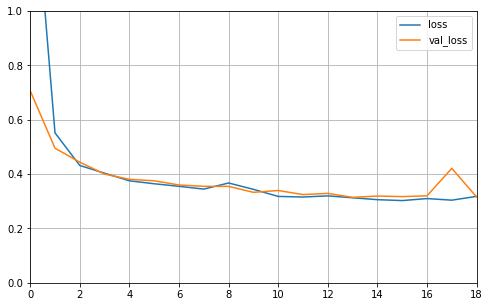

In [10]:
# 画图展示变化，打印学习曲线
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()
    
plot_learning_curves(history)

In [ ]:
# 在测试集上进行指标评估
model.evaluate(x_test_scaled,y_test)

#### 子类API构建Wide&Deep模型

In [12]:
# 子类API构建模型
class WideDeepModel(keras.models.Model):
    def __init__(self):
        super(WideDeepModel,self).__init__()
        """定义模型的层次"""
        self.hidden1_layer = keras.layers.Dense(30, activation='relu')
        self.hidden2_layer = keras.layers.Dense(30, activation='relu')
        self.output_layer = keras.layers.Dense(1)
        
    def call(self,input):
        """完成模型的正向计算"""
        hidden1 = self.hidden1_layer(input)
        hidden2 = self.hidden2_layer(hidden1)
        concat = keras.layers.concatenate([input,hidden2])
        output = self.output_layer(concat)
        return output
    
# 使用子类，固化模型
model = WideDeepModel()
# 另外一种写法
# model = keras.models.Sequential([WideDeepModel(),])
model.build(input_shape=(None,8))
model.summary()

# 模型编译
model.compile(loss='mean_squared_error',optimizer='adam')

# 回调函数
callbacks = [keras.callbacks.EarlyStopping(patience=5,min_delta=1e-3)]

Model: "wide_deep_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              multiple                  270       
_________________________________________________________________
dense_7 (Dense)              multiple                  930       
_________________________________________________________________
dense_8 (Dense)              multiple                  39        
Total params: 1,239
Trainable params: 1,239
Non-trainable params: 0
_________________________________________________________________


In [13]:
# 模型训练
history_subclass = model.fit(x_train_scaled,y_train,epochs=100,
                    validation_data=(x_valid_scaled,y_valid),
                    callbacks=callbacks)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 2s 186us/sample - loss: 1.0927 - val_loss: 0.5573
Epoch 2/100
11610/11610 [==============================] - 1s 126us/sample - loss: 0.4606 - val_loss: 0.4489
Epoch 3/100
11610/11610 [==============================] - 1s 122us/sample - loss: 0.4099 - val_loss: 0.4260
Epoch 4/100
11610/11610 [==============================] - 1s 121us/sample - loss: 0.3853 - val_loss: 0.3916
Epoch 5/100
11610/11610 [==============================] - 1s 118us/sample - loss: 0.4051 - val_loss: 0.3800
Epoch 6/100
11610/11610 [==============================] - 1s 119us/sample - loss: 0.3831 - val_loss: 0.3714
Epoch 7/100
11610/11610 [==============================] - 1s 121us/sample - loss: 0.3557 - val_loss: 0.3586
Epoch 8/100
11610/11610 [==============================] - 1s 123us/sample - loss: 0.3464 - val_loss: 0.3619
Epoch 9/100
11610/11610 [==============================] - 1s 121us/sample - lo

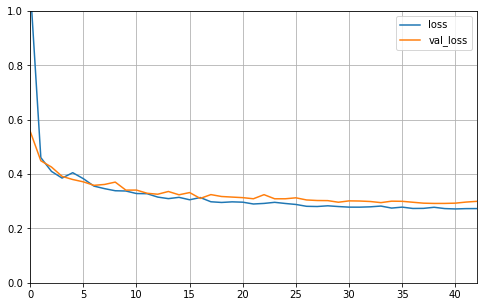

In [14]:
plot_learning_curves(history_subclass)

In [ ]:
# 测试集上进行指标评估
model.evaluate(x_test_scaled,y_test)

#### 多输入构建模型

In [17]:
# 构建模型
input_wide = keras.layers.Input(shape=[5])
input_deep = keras.layers.Input(shape=[6])
hidden1 = keras.layers.Dense(30, activation='relu')(input_deep)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat = keras.layers.concatenate([input_wide,hidden2])
output = keras.layers.Dense(1)(concat)

#固化模型
model = keras.models.Model(inputs=[input_wide,input_deep],outputs=[output])
model.summary()

# 模型编译
model.compile(loss='mean_squared_error',optimizer='adam')

# 回调函数
callbacks = [keras.callbacks.EarlyStopping(patience=5,min_delta=1e-3)]

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 30)           210         input_4[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 30)           930         dense_9[0][0]                    
____________________________________________________________________________________________

In [22]:
x_train_scaled_wide = x_train_scaled[:,:5]
x_train_scaled_deep = x_train_scaled[:,2:]
x_valid_scaled_wide = x_valid_scaled[:,:5]
x_valid_scaled_deep = x_valid_scaled[:,2:]
x_test_scaled_wide = x_test_scaled[:,:5]
x_test_scaled_deep = x_test_scaled[:,2:]

# 模型训练
history_mutil_input = model.fit([x_train_scaled_wide,x_train_scaled_deep],
                                y_train,
                                validation_data=([x_valid_scaled_wide,x_valid_scaled_deep],
                                                 y_valid),
                                epochs=100,
                                callbacks=callbacks)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 2s 191us/sample - loss: 1.4356 - val_loss: 0.6161
Epoch 2/100
11610/11610 [==============================] - 1s 123us/sample - loss: 0.4876 - val_loss: 0.4660
Epoch 3/100
11610/11610 [==============================] - 1s 127us/sample - loss: 0.4206 - val_loss: 0.4248
Epoch 4/100
11610/11610 [==============================] - 2s 133us/sample - loss: 0.3989 - val_loss: 0.4111
Epoch 5/100
11610/11610 [==============================] - 2s 134us/sample - loss: 0.3878 - val_loss: 0.3968
Epoch 6/100
11610/11610 [==============================] - 2s 135us/sample - loss: 0.3768 - val_loss: 0.3810
Epoch 7/100
11610/11610 [==============================] - 2s 138us/sample - loss: 0.3634 - val_loss: 0.3790
Epoch 8/100
11610/11610 [==============================] - 2s 138us/sample - loss: 0.3649 - val_loss: 0.3871
Epoch 9/100
11610/11610 [==============================] - 2s 140us/sample - lo

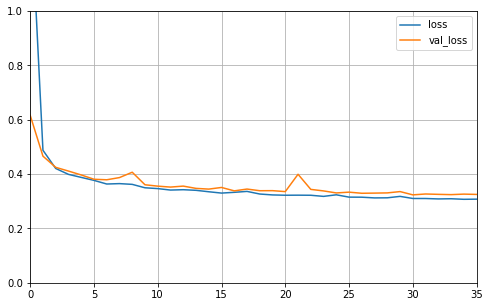

In [23]:
plot_learning_curves(history_mutil_input)

In [ ]:
# 测试集上进行指标评估
model.evaluate([x_test_scaled_wide,x_test_scaled_deep],y_test)

#### 多输出实战

In [25]:
# 构建模型
input_wide = keras.layers.Input(shape=[5])
input_deep = keras.layers.Input(shape=[6])
hidden1 = keras.layers.Dense(30, activation='relu')(input_deep)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat = keras.layers.concatenate([input_wide,hidden2])
output = keras.layers.Dense(1)(concat)
output2 = keras.layers.Dense(1)(hidden2)

#固化模型
model = keras.models.Model(inputs=[input_wide,input_deep],
                           outputs=[output,output2])
model.summary()

# 模型编译
model.compile(loss='mean_squared_error',optimizer='adam')

# 回调函数
callbacks = [keras.callbacks.EarlyStopping(patience=5,min_delta=1e-3)]

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 30)           210         input_6[0][0]                    
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 30)           930         dense_12[0][0]                   
____________________________________________________________________________________________

In [26]:
# 模型训练
history_mutil_output = model.fit([x_train_scaled_wide,x_train_scaled_deep],
                                 [y_train,y_train],
                                validation_data=([x_valid_scaled_wide,x_valid_scaled_deep],
                                                 [y_valid,y_valid]),
                                epochs=100,
                                callbacks=callbacks)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 3s 258us/sample - loss: 3.4015 - dense_14_loss: 1.4283 - dense_15_loss: 1.9722 - val_loss: 1.5721 - val_dense_14_loss: 0.6343 - val_dense_15_loss: 0.9377
Epoch 2/100
11610/11610 [==============================] - 2s 183us/sample - loss: 1.1932 - dense_14_loss: 0.5007 - dense_15_loss: 0.6923 - val_loss: 1.1078 - val_dense_14_loss: 0.4694 - val_dense_15_loss: 0.6382
Epoch 3/100
11610/11610 [==============================] - 2s 185us/sample - loss: 1.0124 - dense_14_loss: 0.4289 - dense_15_loss: 0.5835 - val_loss: 1.0060 - val_dense_14_loss: 0.4315 - val_dense_15_loss: 0.5744
Epoch 4/100
11610/11610 [==============================] - 2s 186us/sample - loss: 0.9577 - dense_14_loss: 0.4111 - dense_15_loss: 0.5465 - val_loss: 0.9635 - val_dense_14_loss: 0.4107 - val_dense_15_loss: 0.5526
Epoch 5/100
11610/11610 [==============================] - 2s 189us/sample - loss: 0.9079 - dense_1

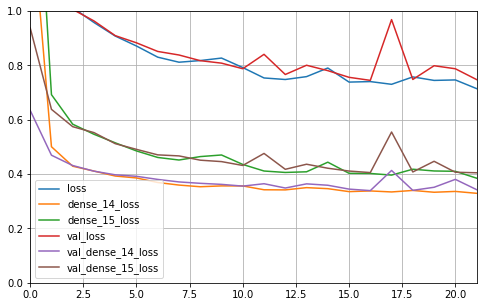

In [27]:
plot_learning_curves(history_mutil_output)

In [ ]:
# 测试集上进行指标评估
model.evaluate([x_test_scaled_wide,x_test_scaled_deep],[y_test,y_test])